# KDSH - Algorithmic trading for Bitcoin

THe following jupyter notebook contains submitted for the Kharagpur Data Science Hackathon - 2024

In [ ]:
import pandas as pd
from ta.trend import SMAIndicator, MACD
from ta.volatility import BollingerBands
from ta.momentum import RSIIndicator
from ta.volume import ChaikinMoneyFlowIndicator
from sklearn.cluster import KMeans
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import warnings
import ta
import xgboost as xgb
import matplotlib.dates as mdates
from matplotlib.ticker import MaxNLocator

## Choosing Indicators

The following indicators have been chosen for the model:

- **Relative Strength Index (RSI)** : The 7, 14 and 21 day RSI were calculated.
- **Moving Average Convergence Divergence** : MACD is a trend-following momentum indicator that highlights the relationship between two moving averages, signaling potential buy or sell opportunities based on their convergence or divergence.
- **Chaikin Money flow line (AD Line)**: CMF assesses the flow of money by combining price and volume data. Positive CMF indicates buying pressure, while negative values suggest selling pressure.
- **William Percent Range**: Williams %R is a momentum oscillator gauging overbought and oversold levels. Readings above -20 indicate overbought conditions, while below -80 suggests oversold conditions.



In [65]:
# Assuming df is your DataFrame with 'open', 'high', 'low', 'close', and 'volume' columns

df = pd.read_csv('btc_2h.csv')
print(df['datetime'][len(df) - 1])
# Calculating Relative Strength Index (RSI)
df['RSI7'] = RSIIndicator(df['close'], window=7).rsi()
df['RSI14'] = RSIIndicator(df['close'], window=14).rsi()
df['RSI21'] = RSIIndicator(df['close'], window=21).rsi()

# Calculating MACD
macd = MACD(df['close'], window_slow=26, window_fast=12, window_sign=9)
df['MACD_HIST'] = macd.macd_diff()

# Calculating Chaikin Money Flow (AD line)
df['AD'] = ChaikinMoneyFlowIndicator(df['high'], df['low'], df['close'], df['volume']).chaikin_money_flow()
df['William_Percent_Range'] = ta.momentum.williams_r(df['high'], df['low'], df['close'], lbp=14)
df

2022-01-31 05:30:00


,datetime,open,high,low,close,volume,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range
0,2018-01-01 05:30:00,13715.65,13715.65,13155.38,13203.06,827.053205,NaN,NaN,NaN,NaN,NaN,NaN
1,2018-01-01 07:30:00,13203.00,13611.27,13200.00,13410.03,849.151602,NaN,NaN,NaN,NaN,NaN,NaN
2,2018-01-01 09:30:00,13434.98,13699.00,13322.15,13558.99,745.036375,NaN,NaN,NaN,NaN,NaN,NaN
3,2018-01-01 11:30:00,13539.00,13818.55,13510.00,13570.35,557.178461,NaN,NaN,NaN,NaN,NaN,NaN
4,2018-01-01 13:30:00,13569.98,13735.24,13400.00,13616.99,484.909382,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
17837,2022-01-30 21:30:00,37977.47,38074.76,37751.72,37991.00,1141.092080,51.668626,54.498744,54.513946,-40.502930,0.139355,-50.247194
17838,2022-01-30 23:30:00,37991.00,38020.39,37442.52,37512.37,2210.156590,34.779755,46.450866,49.610159,-74.166374,0.053838,-86.104876
17839,2022-01-31 01:30:00,37512.37,37762.60,37351.63,37729.00,1911.983080,44.379771,50.046413,51.675990,-79.685341,0.120439,-72.436839
17840,2022-01-31 03:30:00,37729.00,38230.00,37625.41,37881.76,2463.470350,50.387600,52.469986,53.099657,-71.168994,0.086099,-61.279225


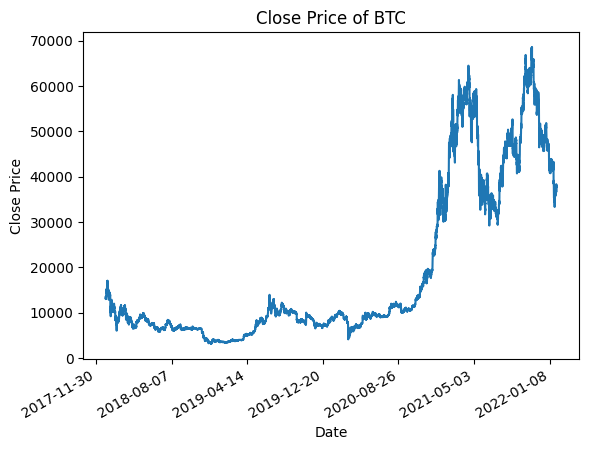

In [66]:
plt.plot(pd.to_datetime(df['datetime']), df['close'])
plt.ylabel('Close Price')
plt.xlabel('Date')
plt.title('Close Price of BTC')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(MaxNLocator(8))  # Adjust '5' based on your desired number of ticks
# Optional: Adjust tick interval

# Rotating x-axis tick labels for better readability
plt.gcf().autofmt_xdate()


Price of buy and sell is decided by the next day's open price

In [67]:
df = df.dropna()
df['price']=df.open.shift(-1)
df = df.drop(['datetime'], axis = 1)
df = df.dropna()

In [8]:
df

,open,high,low,close,volume,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range,price
33,14800.00,14899.86,14671.00,14700.01,792.750301,52.426274,58.614210,60.010717,-28.660792,0.073790,-39.253181,14700.01
34,14700.01,14990.00,14683.00,14926.96,535.314197,59.947740,62.132386,62.595713,-28.392790,0.089636,-31.810880,14926.96
35,14926.96,14949.00,14710.00,14919.51,909.583365,59.586946,61.946224,62.456555,-30.774180,0.072928,-33.523100,14919.51
36,14919.51,15179.00,14649.99,15172.12,2002.474003,67.358353,65.699054,65.210157,-18.024761,0.119206,-11.700473,15175.00
37,15175.00,15280.00,15059.00,15119.97,1060.061643,64.376699,64.289475,64.189629,-15.867977,0.112630,-16.205639,15119.97
...,...,...,...,...,...,...,...,...,...,...,...,...
17836,37963.21,38041.32,37712.05,37980.09,1665.327300,51.205689,54.331271,54.416130,-35.811541,0.076311,-50.998416,37977.47
17837,37977.47,38074.76,37751.72,37991.00,1141.092080,51.668626,54.498744,54.513946,-40.502930,0.139355,-50.247194,37991.00
17838,37991.00,38020.39,37442.52,37512.37,2210.156590,34.779755,46.450866,49.610159,-74.166374,0.053838,-86.104876,37512.37
17839,37512.37,37762.60,37351.63,37729.00,1911.983080,44.379771,50.046413,51.675990,-79.685341,0.120439,-72.436839,37729.00


## Clustering

The entries are clustered in to identify market trends based on the indicators generated above.


In [5]:
df_cluster = df.iloc[:, 5:len(df.columns)-1]
df_cluster

,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range
33,52.426274,58.614210,60.010717,-28.660792,0.073790,-39.253181
34,59.947740,62.132386,62.595713,-28.392790,0.089636,-31.810880
35,59.586946,61.946224,62.456555,-30.774180,0.072928,-33.523100
36,67.358353,65.699054,65.210157,-18.024761,0.119206,-11.700473
37,64.376699,64.289475,64.189629,-15.867977,0.112630,-16.205639
...,...,...,...,...,...,...
17836,51.205689,54.331271,54.416130,-35.811541,0.076311,-50.998416
17837,51.668626,54.498744,54.513946,-40.502930,0.139355,-50.247194
17838,34.779755,46.450866,49.610159,-74.166374,0.053838,-86.104876
17839,44.379771,50.046413,51.675990,-79.685341,0.120439,-72.436839


In [6]:
X = df_cluster.to_numpy()
train_length = 12000
X_train = X[:train_length]
kmeans = KMeans(n_clusters = 3, n_init = "auto").fit(X_train)
labels = kmeans.labels_
df_train = df_cluster.iloc[:len(X_train)]
df_train

,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range
33,52.426274,58.614210,60.010717,-28.660792,0.073790,-39.253181
34,59.947740,62.132386,62.595713,-28.392790,0.089636,-31.810880
35,59.586946,61.946224,62.456555,-30.774180,0.072928,-33.523100
36,67.358353,65.699054,65.210157,-18.024761,0.119206,-11.700473
37,64.376699,64.289475,64.189629,-15.867977,0.112630,-16.205639
...,...,...,...,...,...,...
12028,51.274169,46.813901,46.215536,8.170355,-0.229177,-38.673273
12029,48.727798,45.792783,45.540351,9.271544,-0.219222,-43.909992
12030,47.066873,45.146864,45.118804,9.402547,-0.154434,-47.099505
12031,47.044673,45.138727,45.113601,9.481728,-0.024403,-32.017699


In [7]:
print(labels)
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts))
df_train['label'] = labels
df_train

[0 0 0 ... 0 0 0]


C:\Users\ACER\AppData\Local\Temp\ipykernel_8508\2248231060.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['label'] = labels


,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range,label
33,52.426274,58.614210,60.010717,-28.660792,0.073790,-39.253181,0
34,59.947740,62.132386,62.595713,-28.392790,0.089636,-31.810880,0
35,59.586946,61.946224,62.456555,-30.774180,0.072928,-33.523100,0
36,67.358353,65.699054,65.210157,-18.024761,0.119206,-11.700473,1
37,64.376699,64.289475,64.189629,-15.867977,0.112630,-16.205639,1
...,...,...,...,...,...,...,...
12028,51.274169,46.813901,46.215536,8.170355,-0.229177,-38.673273,0
12029,48.727798,45.792783,45.540351,9.271544,-0.219222,-43.909992,0
12030,47.066873,45.146864,45.118804,9.402547,-0.154434,-47.099505,0
12031,47.044673,45.138727,45.113601,9.481728,-0.024403,-32.017699,0


In [8]:
unique_elements, counts = np.unique(df_train['label'], return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0: 5264 times
1: 4294 times
2: 2442 times


## Target label for each day

Two values *a* and *b* are calculated. The mean and standard deviation of the difference between adjacent days are calculated. Then a and b are set 0.2 and 1 standard deviation away from the mean. Only when the target is between and b, a trade is executed. This acts as a risk prevention method as trades are not executed for very small or very large price fluctuations.

In [9]:
avg_diff=df.iloc[:len(df_train), 3].diff().mean()
std_dev=df.iloc[:len(df_train), 3].diff().std()
a = avg_diff + 0.2*std_dev
b = avg_diff + std_dev
print(a)
print(b)

20.891537364334937
105.84558914686845


In [10]:


# 0 buy 1 sell 2 hold

l=[]

# for i in range(len(df_train) - 1):
#   if(df_train.iloc[i]['price'] > df_train.iloc[i+1]['price']):
#     l.append(0)
#   else:
#     l.append(1)

close = list(df.iloc[:len(df_train), 3])
for i in range(len(df_train)-1):
    if close[i] > close[i+1]:
      if (close[i] - close[i+1])>a and (close[i] - close[i+1])<b:
        l.append(1)
      else:
        l.append(2)
    else:
      if (close[i+1] - close[i])>a and (close[i+1] - close[i])<b:
        l.append(0)
      else:
        l.append(2)
l.append(1)
df_train['target']=l


C:\Users\ACER\AppData\Local\Temp\ipykernel_8508\3014275574.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['target']=l


In [79]:
df_train

,RSI7,RSI14,RSI21,MACD_HIST,AD,William_Percent_Range,label,target
datetime,,,,,,,,
2018-01-03 23:30:00,52.426274,58.614210,60.010717,-28.660792,0.073790,-39.253181,2,2
2018-01-04 01:30:00,59.947740,62.132386,62.595713,-28.392790,0.089636,-31.810880,2,2
2018-01-04 03:30:00,59.586946,61.946224,62.456555,-30.774180,0.072928,-33.523100,2,2
2018-01-04 05:30:00,67.358353,65.699054,65.210157,-18.024761,0.119206,-11.700473,1,1
2018-01-04 07:30:00,64.376699,64.289475,64.189629,-15.867977,0.112630,-16.205639,1,2
...,...,...,...,...,...,...,...,...
2020-10-03 07:30:00,51.274169,46.813901,46.215536,8.170355,-0.229177,-38.673273,2,2
2020-10-03 09:30:00,48.727798,45.792783,45.540351,9.271544,-0.219222,-43.909992,2,2
2020-10-03 11:30:00,47.066873,45.146864,45.118804,9.402547,-0.154434,-47.099505,2,2


In [121]:
print(X_train[0])

[ 52.42627418  58.61420998  60.01071742 -28.66079225   0.07378959
 -39.25318068]


In [30]:
print(X_train)

[[ 5.24262742e+01  5.86142100e+01  6.00107174e+01 -2.86607923e+01
   7.37895905e-02 -3.92531807e+01]
 [ 5.99477403e+01  6.21323860e+01  6.25957135e+01 -2.83927896e+01
   8.96363101e-02 -3.18108797e+01]
 [ 5.95869463e+01  6.19462237e+01  6.24565550e+01 -3.07741803e+01
   7.29279537e-02 -3.35231003e+01]
 ...
 [ 4.70668726e+01  4.51468637e+01  4.51188039e+01  9.40254671e+00
  -1.54433773e-01 -4.70995045e+01]
 [ 4.70446731e+01  4.51387274e+01  4.51136009e+01  9.48172827e+00
  -2.44030831e-02 -3.20176991e+01]
 [ 4.93285390e+01  4.59972144e+01  4.56526178e+01  1.00846847e+01
  -1.07764884e-01 -2.80309735e+01]]


## Training the Model

Now for each trading instance, the cluster it belongs to is identified. Now the previous 300 entries(i.e. one quarter) belonging to the same cluster as the test instance are gathered and a XGBoost model is trained on them. This predicts the label as 0 (buy), 1 (sell) or 2 (hold).
Based on this, trades are executed.

In [11]:
def predict(x):
  label = kmeans.predict(x)[0]

  i = len(X_train) - 1
  m = len(df_train.columns)
  window = np.zeros((300, m - 2))
  y = []
  cnt = 0
  while(i>0 and cnt<300):
    if(df_train['label'][i] == label):
      window[cnt] = X_train[i]
      y.append(df_train['target'][i])
      cnt = cnt + 1
    i = i - 1
  if(len(np.unique(y)) == 1):
    return [y[0]]
  unique_elements, counts = np.unique(y, return_counts=True)

  X_train_clf = window
  
  dtrain = xgb.DMatrix(X_train_clf, label = y)
  params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y)),
    'eta': 0.3,
    'max_depth': 3,
    'eval_metric': 'merror'
}
  num_round = 100
  model = xgb.train(params, dtrain, num_round)
  
  d_test = xgb.DMatrix(x)
  y_pred = model.predict(d_test)

  return y_pred,label

In [12]:
unique_elements, counts = np.unique(df_train['target'], return_counts=True)

# Print the results
for element, count in zip(unique_elements, counts):
    print(f"{element}: {count} times")

0: 2726 times
1: 2604 times
2: 6670 times


## Testing the model

The first 12000 instances were utilized for the training part. For the remaining part the model is tested. Based on the buy or signal received the model executes trades.

In [14]:
warnings.simplefilter('ignore')

initial_amount = 1000

amt = initial_amount
buy_signal = None
buy_datetime = None
sell_datetime = None

trades=[]
l=[]
pred=[]

buy=True
sell=False
trades=[]

for i in range(len(df_train), len(df)-1):
  x = df.iloc[i, 5:len(df.columns)-1]
  prediction,label = predict(x.to_numpy().reshape(1,-1))
  prediction = prediction[0]
  pred.append(prediction)
  l.append(label)
  if(prediction == 0 and buy):
    bp=df['price'][i]
    buy=False
    sell=True
  elif(prediction == 1 and sell):
    sp=df['price'][i]
    trades.append({'buy':bp,'sell':sp})
    buy=True
    sell=False

In [63]:
def trading(init_amt, trades):
  amt = init_amt
  am=[]
  profitable = []
  loss_trade = []
  transaction_cost = 0
  diff = []
  for i in trades:
    if(i['sell'] - i['buy'] > 0):
      profitable.append((amt/i['buy'])*(i['sell']-i['buy']))
    else:
      loss_trade.append((amt/i['buy'])*(i['sell']-i['buy']))
    diff.append((amt/i['buy'])*(i['sell']-i['buy']))
    transaction_cost += (amt/i['buy'])*0.0015*(i['buy'] + i['sell'])
    amt+=(amt/i['buy'])*(i['sell']-i['buy'])
    
    am.append(amt)
  plt.plot(am)
  plt.xlabel('Trade')
  plt.ylabel('Portfolio amount in USD')
  plt.title('Portfolio vs Trade number')
  drawdowns = []
  diff = np.array(diff)
  profitable = np.array(profitable)
  loss_trade = np.array(loss_trade)
  for i in range(1, len(am)):
      peak_value = max(am[:i + 1])
      drawdown = (am[i] - peak_value) / peak_value * 100
      drawdowns.append(drawdown)
  
  max_drawdown = min(drawdowns)
  max_profit = np.max(diff)
  max_loss = np.min(diff)
  avg_win = np.mean(profitable)
  avg_loss = np.mean(loss_trade)
  sharpe=np.mean(diff)/np.std(diff)
  
  average_return = np.mean(diff)
  downside_returns = [r for r in diff if r < 0]
  downside_deviation = np.std(downside_returns) if len(downside_returns) > 0 else 0
  sortino_ratio = average_return / downside_deviation if downside_deviation > 0 else 0
  
  buy_and_hold = (initial_amount/df['price'][len(df_train)]*(df['price'][len(df) - 1] - df['price'][len(df_train)])) - init_amt
  
  
  print(f'Gross Profit: {am[-1] - init_amt}')
  print(f'Net Profit: {am[-1] - init_amt - transaction_cost}')
  print(f'Drawdown: {-1*max_drawdown}%')
  print(f'Number of Trades: {len(trades)}')
  print(f'Win rate: {100*len(profitable)/len(trades)}%')
  print(f'Maximum Profit: {max_profit}')
  print(f'Average Winning Trade: {avg_win}')
  print(f'Average Losing Trade: {avg_loss}')
  print(f'Maximum Loss: {max_loss}')
  print(f'Sharpe Ratio: {sharpe}')
  print(f'Sortino Ratio: {sortino_ratio}')
  print(f'Buy and Hold return: {100 * buy_and_hold/ init_amt}%')
  print(f'risk-reward', len(profitable)/len(loss_trade))

Gross Profit: 7823.715179536193
Net Profit: 2636.119353946776
Drawdown: 36.92283068387092%
Number of Trades: 313
Win rate: 58.466453674121404%
Maximum Profit: 1289.2104153426226
Average Winning Trade: 140.3899002144245
Average Losing Trade: -137.4433581515653
Maximum Loss: -1414.7242219244627
Sharpe Ratio: 0.10623663507875687
Sortino Ratio: 0.12564159994368873
Buy and Hold return: 147.5107598389013%
risk-reward 1.4076923076923078


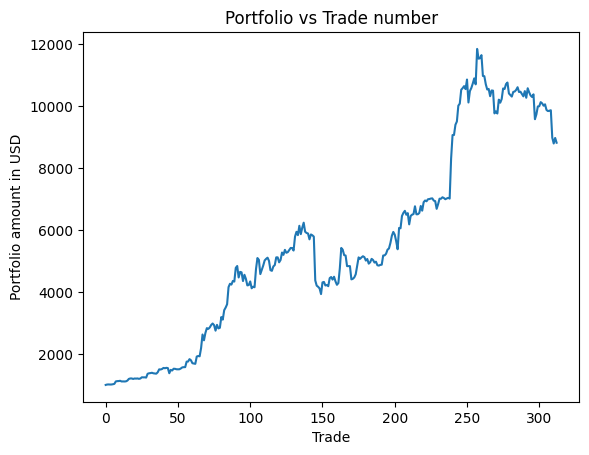

In [68]:
trading(1000, trades)

The XGBoost model is also trained on the full training data as a control for our clustering model. This was a catastrophic failure, resulting in an overall loss. This further strengthens the reliability of the clustering model.

In [38]:
y = df_train['target']   
dtrain_full = xgb.DMatrix(X_train, label = y)
params = {
'objective': 'multi:softmax',
'num_class': len(set(y)),
'eta': 0.3,
'max_depth': 3,
'eval_metric': 'merror'
}
num_round = 100
model = xgb.train(params, dtrain_full, num_round)
def predict_full(x):
    d_test = xgb.DMatrix(x)
    y_pred = model.predict(d_test)
    return y_pred, label

In [39]:
warnings.simplefilter('ignore')

initial_amount = 1000
amt = initial_amount
buy=True
sell=False
trades_full=[]
l_full=[]
pred_full=[]
for i in range(len(df_train), len(df)-1):
  x = df.iloc[i, 5:len(df.columns)-1]
  prediction,label = predict_full(x.to_numpy().reshape(1,-1))
  prediction = prediction[0]
  pred_full.append(prediction)
  l_full.append(label)
  if(prediction == 0 and buy):
    bp=df['price'][i]
    buy=False
    sell=True
  elif(prediction == 1 and sell):
    sp=df['price'][i]
    trades_full.append({'buy':bp,'sell':sp})
    buy=True
    sell=False

Gross Profit: -234.97399163270836
Net Profit: -469.9467547563579
Drawdown: 57.3169674136299%
Number of Trades: 60
Win rate: 58.333333333333336%
Maximum Profit: 129.28715503901086
Maximum Loss: -539.0572808451795
Sharpe Ratio: -0.0429102383562824
Sortino Ratio: -0.037805394954402986
Buy and Hold return: 247.5107598389013%


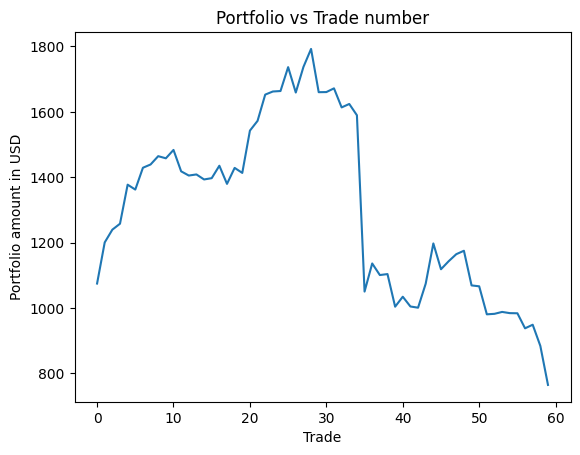

In [43]:
trading(1000, trades_full)